In [1]:
import pandas as pd
import re as re
import numpy as np

df = pd.read_csv('data/booksummaries.txt',sep='\t', names = ["Wiki ID", "Freebase ID", "Title", "Author", "Publication Date", "Genres", "Summary" ])

In [2]:
df.head()

,Wiki ID,Freebase ID,Title,Author,Publication Date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [3]:
df = df[['Title', 'Genres', 'Summary']]

In [4]:
df.isnull().sum()

Title         0
Genres     3718
Summary       0
dtype: int64

In [5]:
df.dropna(subset=['Genres'], inplace=True)

In [6]:
df.isnull().sum()

Title      0
Genres     0
Summary    0
dtype: int64

In [7]:
df.shape

(12841, 3)

In [8]:
print(df.loc[[0]])

         Title                                             Genres  \
0  Animal Farm  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   

                                             Summary  
0   Old Major, the old boar on the Manor Farm, ca...  


In [9]:
df.Genres[0]

'{"/m/016lj8": "Roman \\u00e0 clef", "/m/06nbt": "Satire", "/m/0dwly": "Children\'s literature", "/m/014dfn": "Speculative fiction", "/m/02xlf": "Fiction"}'

In [10]:
type(df.Genres[0])

str

In [11]:
import json
type(json.loads(df['Genres'][0]))

dict

In [12]:
json.loads(df['Genres'][0]).values()

dict_values(['Roman à clef', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction'])

In [13]:
# Create new list for genres
genres = []

# Extract genres
for i in df['Genres']: 
  genres.append(list(json.loads(i).values())) 

# Add to 'genres' dataframe  
df['Genres'] = genres

In [14]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

227

In [15]:
import nltk
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [16]:
all_genres_df.head()

,Genre,Count
0,Roman à clef,29
1,Satire,123
2,Children's literature,2122
3,Speculative fiction,4314
4,Fiction,4747


In [17]:
all_genres_df.sort_values(by='Count', ascending = False)

,Genre,Count
4,Fiction,4747
3,Speculative fiction,4314
5,Science Fiction,2870
10,Novel,2463
12,Fantasy,2413
...,...,...
187,Fable,1
188,Bangsian fantasy,1
189,Space western,1
194,Fantastique,1


In [18]:
print(all_genres_df['Genre'][0])

Roman à clef


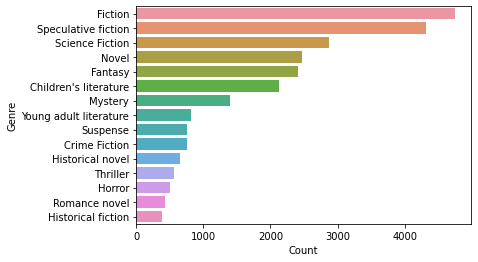

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns

g = all_genres_df.nlargest(columns="Count", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.show()

In [20]:
all_genres_df = all_genres_df.to_dict()

In [21]:
low_freq = []
for i in range(len(all_genres_df['Count'])):
    if all_genres_df['Count'][i] <= 50:
        low_freq.append(all_genres_df['Genre'][i])


In [22]:
len(low_freq)

189

In [23]:
df = df.reset_index(drop=True)

In [24]:
df.head()

,Title,Genres,Summary
0,Animal Farm,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,The Plague,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
3,A Fire Upon the Deep,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...
4,All Quiet on the Western Front,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."


In [25]:
index_delete = []
for word in low_freq:
    for i in range(len(df.Genres)):
        if word in df.Genres[i]:
            if i not in index_delete:
                index_delete.append(i)        

In [26]:
df.drop(index_delete , inplace=True)

In [27]:
df.shape

(11283, 3)

In [28]:
df.head()

,Title,Genres,Summary
1,A Clockwork Orange,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
6,Blade Runner 3: Replicant Night,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul..."
7,Blade Runner 2: The Edge of Human,"[Science Fiction, Speculative fiction]",Beginning several months after the events in ...
9,Crash,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...
10,Children of Dune,"[Science Fiction, Speculative fiction, Childre...",Nine years after Emperor Paul Muad'dib walked...


In [29]:
df = df.reset_index(drop=True)

In [30]:
# Create new list for genres
genres = []

# extract genres
for i in range(len(df['Genres'])): 
  genres.append(df['Genres'][i]) 

In [31]:
# get all genre tags in a list

all_genres = sum(genres,[])
len(set(all_genres))

38

In [32]:
print(set(all_genres))

{'Humour', 'Autobiography', 'Comic novel', 'Satire', 'Gothic fiction', "Children's literature", 'Spy fiction', 'Memoir', 'Fiction', 'Speculative fiction', 'Alternate history', 'History', 'War novel', 'Short story', 'Non-fiction', 'Historical fiction', 'Horror', 'Young adult literature', 'Apocalyptic and post-apocalyptic fiction', 'Science Fiction', 'Novella', 'Thriller', 'Mystery', 'Adventure novel', 'Utopian and dystopian fiction', 'Detective fiction', 'Crime Fiction', 'High fantasy', 'Techno-thriller', 'Fantasy', 'Romance novel', 'Dystopia', 'Autobiographical novel', 'Biography', 'Comedy', 'Novel', 'Historical novel', 'Suspense'}


In [33]:
fiction_sub = ['Spy fiction', 'Gothic fiction', 'Historical fiction', 'Detective fiction', 'Utopian and dystopian fiction', 'Speculative fiction']
len(fiction_sub)

6

In [34]:
def clean_fiction(Genres):
    for i in Genres:
        if i in fiction_sub:
            if 'Fantasy' not in Genres:
                Genres.append('Fantasy')
                Genres.remove(i)
            else:
                Genres.remove(i)
    return Genres
    

In [35]:
df['Genres'] = df['Genres'].apply(lambda x: clean_fiction(x))
df['Genres'] = df['Genres'].apply(lambda x: clean_fiction(x))

In [36]:
df.Genres[6]

['Fantasy']

In [37]:
df.Genres

0        [Science Fiction, Novella, Satire, Fiction, Fa...
1                               [Science Fiction, Fantasy]
2                               [Science Fiction, Fantasy]
3                                [Fiction, Novel, Fantasy]
4        [Science Fiction, Children's literature, Ficti...
                               ...                        
11278                    [Young adult literature, Fantasy]
11279                                    [Science Fiction]
11280                        [Thriller, Fiction, Suspense]
11281                                  [Thriller, Fiction]
11282                                      [Autobiography]
Name: Genres, Length: 11283, dtype: object

In [38]:
import nltk
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [39]:
all_genres_df.head()

,Genre,Count
0,Science Fiction,2615
1,Novella,73
2,Speculative fiction,3893
3,Utopian and dystopian fiction,52
4,Satire,82


In [40]:
all_genres_df = all_genres_df.sort_values(by='Count', ascending = False)
all_genres_df = all_genres_df.reset_index(drop=True)
all_genres_df.head()

,Genre,Count
0,Fiction,4191
1,Speculative fiction,3893
2,Science Fiction,2615
3,Novel,2263
4,Fantasy,2176


In [41]:
df.Summary[0][:300]

' Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random "ultra-violence." Alex\'s friends ("droogs" in the novel\'s Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang\'s muscle; Georgie, an ambitious second-in-command; and Pet'

In [42]:
from nltk.corpus import stopwords
def clean_text(text):
    
    # change all letters to lower case
    text = text.lower()
    
    # remove all numbers from text
    text = re.sub(r'\d+', '', text)
    
    # remove all white spaces from text
    text = text.strip()
    
    # remove all punctuation from text
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

In [43]:
import string
df['Summary'] = df['Summary'].apply(lambda x: clean_text(x))

In [44]:
df.Summary[0][:300]

'alex a teenager living in nearfuture england leads his gang on nightly orgies of opportunistic random ultraviolence alexs friends droogs in the novels anglorussian slang nadsat are dim a slowwitted bruiser who is the gangs muscle georgie an ambitious secondincommand and pete who mostly plays along a'

In [45]:
word_freq = df.Summary.str.split(expand=True).stack().value_counts().rename_axis('Word').reset_index(name='Frequency')

In [46]:
word_freq.head()

,Word,Frequency
0,the,341480
1,to,173240
2,and,165964
3,of,133069
4,a,127906


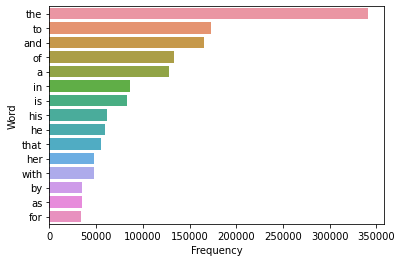

In [47]:
g = word_freq.nlargest(columns="Frequency", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Frequency", y = "Word") 
ax.set(ylabel = 'Word') 
plt.show()

In [48]:
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    # cache stopwords to run faster
    cachedStopWords = stopwords.words("english")   
    
    text_tokens = word_tokenize(text)
    
    # remove all stopwords
    text = [word for word in text_tokens if word not in cachedStopWords]
    
    # remove words with less than 3 characters
    text = [word for word in text if len(word) >= 3]
    text = ' '.join(text)
    
    return text

df['Summary'] = df['Summary'].apply(lambda x: remove_stopwords(x))

In [49]:
df.Summary[0][:300]

'alex teenager living nearfuture england leads gang nightly orgies opportunistic random ultraviolence alexs friends droogs novels anglorussian slang nadsat dim slowwitted bruiser gangs muscle georgie ambitious secondincommand pete mostly plays along droogs indulge taste ultraviolence characterized so'

In [50]:
new_word_freq = df.Summary.str.split(expand=True).stack().value_counts().rename_axis('Word').reset_index(name='Frequency')

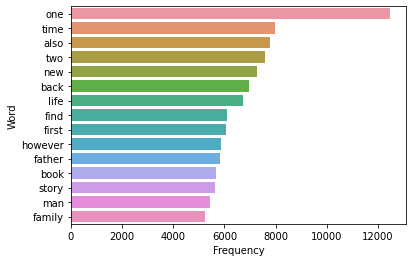

In [51]:
g = new_word_freq.nlargest(columns="Frequency", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Frequency", y = "Word") 
ax.set(ylabel = 'Word') 
plt.show()

In [52]:
df.to_csv('data/clean_data.csv', index = False)

In [53]:
new_word_freq.shape

(119882, 2)

In [54]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['Genres'])

# transform target variable
y = multilabel_binarizer.transform(df['Genres'])

In [55]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [56]:
all_genres_df['Count'][0]/len(df.Genres) # No. Fiction books / All books

0.3714437649561287

In [57]:
from sklearn.model_selection import train_test_split

# split data in train and test set:
x_train, x_test, y_train, y_test = train_test_split(df['Summary'], y, test_size=0.2, random_state=1)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

# create TF-IDF features

x_train_vec = tfidf_vectorizer.fit_transform(x_train).astype('float32')
x_test_vec = tfidf_vectorizer.transform(x_test).astype('float32')

In [59]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
rd = RandomForestClassifier()
clf = OneVsRestClassifier(rd)

# fit model on train data

clf.fit(x_train_vec, y_train)

# make predictions for validation set
y_pred = clf.predict(x_test_vec)

print('f1 score (RD): ', f1_score(y_test, y_pred, average="micro"))

f1 score (RD):  0.3942111058675476


In [60]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data

clf.fit(x_train_vec, y_train)

# make predictions for validation set
y_pred = clf.predict(x_test_vec)

print('f1 score (LR): ',f1_score(y_test, y_pred, average = 'micro'))

f1 score (LR):  0.4353906962602615


In [61]:
multilabel_binarizer.inverse_transform(y)[0]

('Fantasy', 'Fiction', 'Novella', 'Satire', 'Science Fiction')

In [62]:
from keras.preprocessing.text import Tokenizer

tk = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(x_train)

x_train_new = tk.texts_to_sequences(x_train)
x_test_new = tk.texts_to_sequences(x_test)

Using TensorFlow backend.


In [63]:
x_train.shape

(9026,)

In [64]:
from keras.preprocessing import sequence
x_train_new = sequence.pad_sequences(x_train_new, maxlen= 500, padding='pre')
x_test_new = sequence.pad_sequences(x_test_new, maxlen= 500, padding='pre')

In [65]:
max_features = len(tk.word_index) + 1

In [66]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

In [67]:
def build_model():
    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_length, input_length=500))
    model.add(Flatten())
    model.add(Dense(60, activation='relu'))
    model.add(Dense(32, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [68]:
model = build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           3374624   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                960060    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1952      
Total params: 4,336,636
Trainable params: 4,336,636
Non-trainable params: 0
_________________________________________________________________
None


/// GRIDSEARCH for tuning neural network (specifically for finding optimal batch size and epoch count). I only used 4000 samples for this with 2 cross validation folds because my computer is unable to process more. ///

In [ ]:
x_train_g = x_train_new[:4000]
y_train_g = y_train[:4000]

model2 = KerasClassifier(build_fn=build_model, verbose=0)
batch_size = [25, 30, 50]
epochs = [2, 3, 4, 6, 8]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(x_train_g[:3200], y_train_g[:3200], validation_data=(x_train_g[3200:], y_train_g[3200:]))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [70]:
final_model = model.fit(x_train_new, y_train, validation_data=(x_test_new, y_test), epochs=2, batch_size= 25)

Train on 9026 samples, validate on 2257 samples
Epoch 1/2
9026/9026 [==============================] - 12s 1ms/step - loss: 0.0878 - accuracy: 0.9705 - val_loss: 0.1542 - val_accuracy: 0.9442
Epoch 2/2
9026/9026 [==============================] - 11s 1ms/step - loss: 0.0440 - accuracy: 0.9866 - val_loss: 0.1822 - val_accuracy: 0.9454


[]

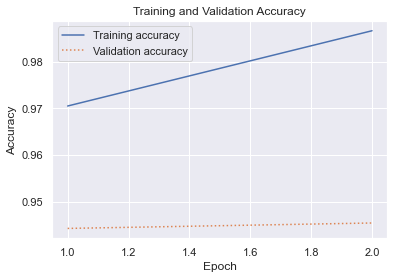

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
acc = final_model.history['accuracy']
val = final_model.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

In [72]:
out = model.predict(x_test_new)

In [73]:
out.shape

(2257, 32)

In [74]:
out[0]

array([6.6161156e-03, 8.8011026e-03, 3.5962462e-03, 7.9510346e-06,
       9.6495728e-07, 3.6013932e-07, 2.6253283e-02, 1.1045635e-03,
       3.3766817e-05, 2.6186895e-06, 6.4314604e-03, 9.9997509e-01,
       1.2156874e-02, 6.5764785e-04, 1.6653538e-04, 5.6084424e-05,
       2.1644980e-02, 4.7323716e-05, 4.3508908e-06, 3.2857060e-04,
       2.5395917e-05, 7.5964928e-03, 2.4575982e-05, 8.6125830e-05,
       3.0202867e-05, 9.5535588e-01, 1.2042095e-04, 3.9047191e-05,
       1.9904971e-04, 1.3718307e-03, 8.9159665e-05, 2.5942326e-03],
      dtype=float32)

In [75]:
out = np.array(out)
y_pred = np.zeros(out.shape)
y_pred[out>0.2]=1
y_pred = np.array(y_pred)

In [76]:
from sklearn.metrics import classification_report

In [77]:
print("f1 score (NN): ", f1_score(y_pred,y_test, average = 'micro'))

f1 score (NN):  0.5110336817653891


In [78]:
scores = model.evaluate(x_test_new, y_test, verbose=0)
print("Accuracy (NN): %.2f%%" % (scores[1] * 100))

Accuracy (NN): 94.54%


In [79]:
multilabel_binarizer.inverse_transform(y_pred)[10]

('Crime Fiction', 'Mystery', 'Thriller')

In [80]:
multilabel_binarizer.inverse_transform(y_test)[10]

('Crime Fiction', 'Fantasy', 'Mystery', 'Suspense')

In [81]:
title_list = df.Title.to_list()

In [82]:
print(title_list)

['A Clockwork Orange', 'Blade Runner 3: Replicant Night', 'Blade Runner 2: The Edge of Human', 'Crash', 'Children of Dune', 'Chapterhouse Dune', 'Carmilla', 'The Cider House Rules', 'Dune Messiah', 'Death of a Hero', 'Fahrenheit 451', 'Farmer Giles of Ham', 'Gaudy Night', 'God Emperor of Dune', 'Gone with the Wind', 'Heretics of Dune', 'Adventures of Huckleberry Finn', 'Ivanhoe', 'Johnny Got His Gun', 'Icehenge', 'Moonfleet', 'Cryptonomicon', 'The Three Stigmata of Palmer Eldritch', 'Time out of Joint', 'Radio Free Albemuth', 'Pride and Prejudice', 'Pale Fire', 'Ringworld', 'Sense and Sensibility', 'Speaker for the Dead', 'Starship Troopers', 'Stuart Little', 'The Shockwave Rider', 'The Shining', 'Mort', 'The Hound of the Baskervilles', 'The Pit and the Pendulum', 'The Hunt for Red October', 'The Cardinal of the Kremlin', 'Debt of Honor', 'Tunnel in the Sky', 'The Picture of Dorian Gray', 'The Sentinel', 'The Fountains of Paradise', 'Lord of the Flies', 'Through the Looking-Glass', 'Th

In [83]:
title_list.index('Clockwork Angel')

11053

In [84]:
df.Genres[11053]

['Fantasy', 'Young adult literature', 'Romance novel']

In [85]:
# output list of titles for use
with open('titles.txt', 'w') as f:
    for title in title_list:
        f.write("%s\n" % title)

In [86]:
def inference_predict(title):
    if title not in title_list:
        print('Title not found.')
        return
    index = title_list.index(title)
    actual_genre = df.Genres[index]
    p_summary = [df.Summary[index]]
    #print(type(p_summary))
    #print(p_summary.shape)
    
    convert = tk.texts_to_sequences(p_summary)
    convert = sequence.pad_sequences(convert, maxlen= 500, padding='pre')
    #print(convert[0])
    
    output = model.predict(convert)
    output = np.array(output)
    #print(output.shape)
    prediction = np.zeros(output.shape)
    prediction[output>0.2]=1
    prediction = np.array(prediction)
    
    print('Title: ', title)
    print('Predicted Genres: ', multilabel_binarizer.inverse_transform(prediction)[0])
    print('Actual Genres: ', actual_genre)

In [87]:
inference_predict("Ender's Game")

Title:  Ender's Game
Predicted Genres:  ('Fantasy', 'Fiction', 'Science Fiction')
Actual Genres:  ['Science Fiction', 'Fiction', 'Fantasy']


In [88]:
inference_predict("Clockwork Angel")

Title:  Clockwork Angel
Predicted Genres:  ('Fantasy', 'Romance novel', 'Young adult literature')
Actual Genres:  ['Fantasy', 'Young adult literature', 'Romance novel']


In [89]:
inference_predict("Dead Air")

Title:  Dead Air
Predicted Genres:  ('Fiction', 'Novel')
Actual Genres:  ['Fiction', 'Novel']


In [90]:
inference_predict("Spartan")

Title:  Spartan
Predicted Genres:  ('Historical novel',)
Actual Genres:  ['Historical novel']


In [91]:
word_index = [word for word in tk.word_index]

In [92]:
def analyse(text):
    text = clean_text(text)
    text = remove_stopwords(text)  
    text = text.split()

    text = [word for word in text if word in word_index]
    text = [' '.join(text)]
    convert = tk.texts_to_sequences(text)
    convert = sequence.pad_sequences(convert, maxlen= 500, padding='pre')

    output = model.predict(convert)
    output = np.array(output)
    prediction = np.zeros(output.shape)
    prediction[output>0.2]=1
    prediction = np.array(prediction)
    
    #print('Clean input: ', text)
    print('Predicted Genres: ', multilabel_binarizer.inverse_transform(prediction)[0]) 

In [93]:
print('Woman in white in data? ', 'The Woman in White' in title_list)
with open('data/WIM_plot.txt', 'r') as file:
    summary1 = file.read().replace('\n', '')
    analyse(summary1)

Woman in white in data?  False
Predicted Genres:  ('Fantasy', 'Fiction', 'Mystery', 'Novel')
